In [1]:
import Spectrum

In [2]:
data = open('example.scr', 'rb').read()

In [23]:
%matplotlib inline
import matplotlib.pyplot as plot
import numpy as np


In [4]:
m = Spectrum.nativeToNumpy(data)

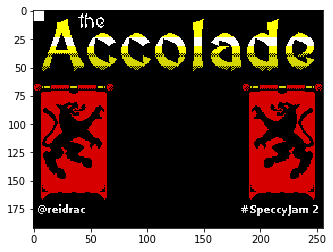

In [10]:
plot.imshow(m)

In [9]:
m[0:10,0:10]=(1.0,1.0,1.0)

In [7]:
191//64

2

In [8]:
m[75,20]

array([0.84313725, 0.        , 0.        ])

In [1]:
32*24*(1+1+1+64)

51456

In [4]:
import keras
from keras import backend as K


In [20]:
def myloss(y_true, y_pred):
    pass

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (9, 9), activation='relu',
                              input_shape=(256, 192, 3), padding='same'))
model.add(keras.layers.Conv2D(32, (9, 9), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(1 + (12 * 17), (9, 9), activation='relu', padding='same'))

adam_opt = keras.optimizers.Adam(0.01)
model.compile(optimizer=adam_opt, loss='mean_squared_error')
model.summary()        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 256, 192, 64)      15616     
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 256, 192, 32)      165920    
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 256, 192, 205)     531565    
Total params: 713,101
Trainable params: 713,101
Non-trainable params: 0
_________________________________________________________________


In [3]:
import cv2

In [16]:
def show(n):
    scr = open('pairs/{}.scr'.format(n), 'rb').read()
    scr = Spectrum.nativeToNumpy(scr)
    rgb = cv2.imread('pairs/{}'.format(n))
    plot.imshow(scr)
    #plot.imshow(rgb)


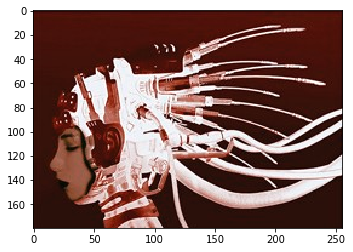

In [15]:
show(123)

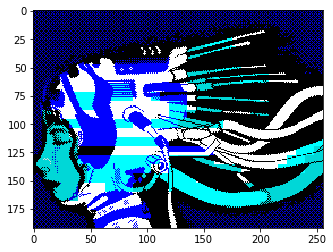

In [17]:
show(123)

In [19]:
rgb = cv2.imread('pairs/1')

In [20]:
rgb.shape

(400, 296, 3)

In [22]:
rgb[0,0,:]

array([19, 35, 42], dtype=uint8)

In [24]:
def read_rgb(pair_no):
    img = cv2.imread('pairs/{}'.format(pair_no))
    img = cv2.resize(img, (256, 192), interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    img /= 255.
    return img


In [27]:
m = read_rgb(123)

In [28]:
m[0,0,:]

array([0.5803922, 0.5921569, 0.7137255], dtype=float32)